In [86]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import F1Score
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [87]:
import os
X = np.empty((1560, 100, 100, 3))
Y = np.empty((1560,))

files = os.listdir('./images/Bicycle')
length = len(files)
for i in range(length):
    x = cv2.imread(f"./images/Bicycle/{files[i]}")
    X[i] = cv2.resize(x, (100, 100))
    Y[i] = 1

files = os.listdir('./images/Other')
for i in range(length):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+length] = cv2.resize(x, (100, 100))
    Y[i+length] = 0


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [89]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(1170, 100, 100, 3)
(390, 100, 100, 3)
(1170,)
(390,)


# 모델 생성

In [90]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
modelpath="./motorcycle.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [93]:

history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=100, verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6690 - accuracy: 0.5177
Epoch 1: val_loss improved from inf to 0.69370, saving model to .\motorcycle.hdf5
9/9 [==============================] - 30s 3s/step - loss: 1.6690 - accuracy: 0.5177 - val_loss: 0.6937 - val_accuracy: 0.4915
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.6374
Epoch 2: val_loss improved from 0.69370 to 0.59117, saving model to .\motorcycle.hdf5
9/9 [==============================] - 22s 2s/step - loss: 0.6469 - accuracy: 0.6374 - val_loss: 0.5912 - val_accuracy: 0.7031
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.5648 - accuracy: 0.7195
Epoch 3: val_loss improved from 0.59117 to 0.54352, saving model to .\motorcycle.hdf5
9/9 [==============================] - 23s 3s/step - loss: 0.5648 - accuracy: 0.7195 - val_loss: 0.5435 - val_accuracy: 0.6997
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.72

In [94]:
print("\n accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

13/13 [==============================] - 3s 206ms/step - loss: 0.4480 - accuracy: 0.8333

 accuracy: 0.8333


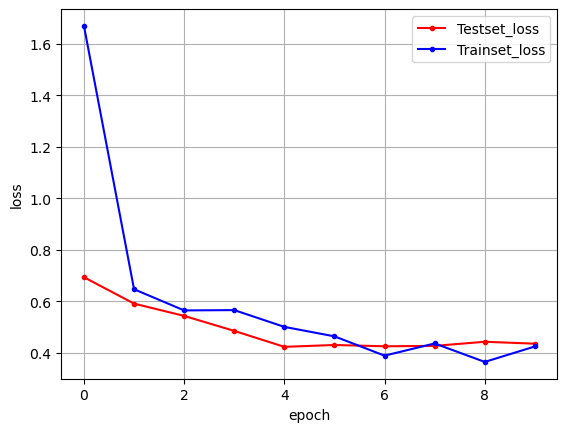

In [95]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [96]:
model.save("motorcycle.h5")